## **Sentiment Analysis of Amazon_product_reviews Using Naive Bayes**

Step 1 : Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import re, string
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer , WordNetLemmatizer
from nltk.tokenize import word_tokenize
# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, classification_report
)
# Setup
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
custom_stopwords = stop_words - {"not", "no", "never"}
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

Step 2 : Upload Dataset

In [ ]:
from google.colab import files

# This will open a file picker dialog in Colab to upload from your local system
uploaded = files.upload()


Step 3 : Load Dataset







In [ ]:
df = pd.read_csv("amazon_product_reviews_sample1.csv")

# Drop rows with missing or empty ReviewText or Sentiment
df = df.dropna(subset=["ReviewText", "Sentiment"])
df = df[df["ReviewText"].str.strip().astype(bool)]
df = df.drop_duplicates(subset=["ReviewText"])


In [ ]:
print(df.columns)

Index(['ProductID', 'ProductName', 'ReviewerID', 'Rating', 'ReviewText',
       'Sentiment', 'ReviewDate', 'HelpfulVotes', 'TotalVotes',
       'HelpfulnessRatio', 'clean_text', 'label'],
      dtype='object')


Step 4 : Data Cleaning & Preprocessing









In [ ]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

# ✅ Define a custom stopword list to retain "not", "no", "never"
custom_stopwords = stop_words - {"not", "no", "never"}

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)               # HTML tags
    text = re.sub(r"http\S+|www.\S+", '', text)     # URLs
    text = re.sub(r"\d+", "", text)                 # Remove digits
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()        # Normalize whitespace
    return text

def preprocess(text):
    text = clean_text(text)
    tokens = word_tokenize(text)

    filtered = []
    for word in tokens:
        if word not in custom_stopwords and len(word) > 2:
            # apply stemming
            stemmed = stemmer.stem(word)
            # apply lemmatization
            lemma = lemmatizer.lemmatize(stemmed)
            filtered.append(lemma)

    return " ".join(filtered)

In [ ]:
df["clean_text"] = df["ReviewText"].astype(str).apply(preprocess)


Step 5: Encode Sentiment Labels

In [ ]:
df = df[df["Sentiment"].isin(["Positive", "Neutral", "Negative"])]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["label"] = le.fit_transform(df["Sentiment"])  # 0: Negative, 1: Neutral, 2: Positive


Step 6: Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["label"],
    test_size=0.2, random_state=42, stratify=df["label"]
)


Step 7: TF-IDF Vectorization + Naive Bayes Model

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, sublinear_tf=True)
X_train_vec = vectorizer.fit_transform(X_train)
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB(alpha=0.5)
model.fit(X_train_vec, y_train)


MultinomialNB(alpha=0.5)

In [ ]:
# Balance the dataset
df_positive = df[df["Sentiment"] == "Positive"]
df_negative = df[df["Sentiment"] == "Negative"]
df_neutral  = df[df["Sentiment"] == "Neutral"]

min_len = min(len(df_positive), len(df_negative), len(df_neutral))
df_balanced = pd.concat([
    df_positive.sample(min_len),
    df_negative.sample(min_len),
    df_neutral.sample(min_len)
])

Step 8 :Evaluation  of Model

In [ ]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)

print("=== Model Evaluation ===")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

=== Model Evaluation ===
Accuracy : 0.974
Precision: 0.975
Recall   : 0.974

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.93      0.97        15
     Neutral       1.00      1.00      1.00         8
    Positive       0.94      1.00      0.97        15

    accuracy                           0.97        38
   macro avg       0.98      0.98      0.98        38
weighted avg       0.98      0.97      0.97        38



Visualize labels

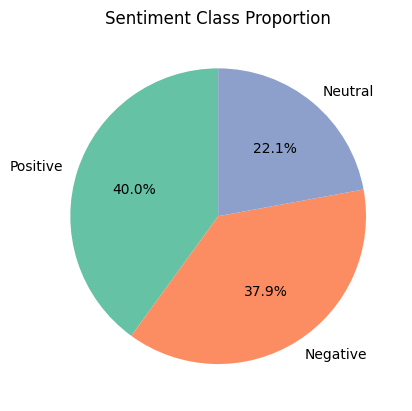

In [ ]:
df["Sentiment"].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=["#66c2a5", "#fc8d62", "#8da0cb"],
    startangle=90,
    title="Sentiment Class Proportion"
)
plt.ylabel("")
plt.show()


Step 9 : Confusion Metrix

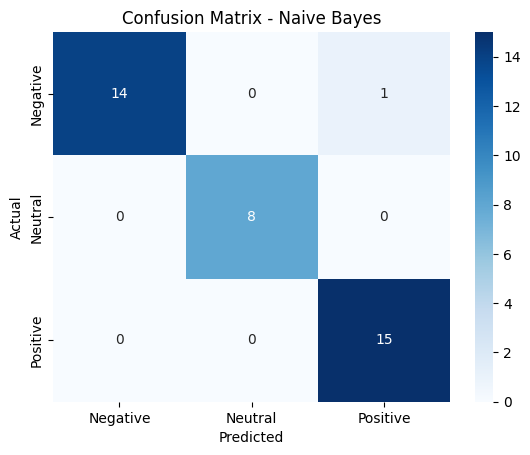

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

Example

In [ ]:
def predict_sentiment(text):
    text_clean = preprocess(text)        # uses your preprocessing fn
    vec = vectorizer.transform([text_clean])
    pred = model.predict(vec)
    return le.inverse_transform(pred)[0]

print(predict_sentiment("Average performance for the price point"))
print(predict_sentiment("This product is a complete failure. So many issues"))
print(predict_sentiment("This is a game-changer! Improved my daily routine significantly"))



Neutral
Negative
Positive


In [ ]:
print(predict_sentiment("This phone is amazing!"))
print(predict_sentiment("Does not work as described. A complete scam"))

Positive
Negative


In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

# Define prediction function for Gradio
def analyze_sentiment(review_text):
    cleaned = preprocess(review_text)
    vec = vectorizer.transform([cleaned])
    pred = model.predict(vec)
    return le.inverse_transform(pred)[0]

# Create Gradio interface
interface = gr.Interface(
    fn=analyze_sentiment,
    inputs=gr.Textbox(lines=4, placeholder="Enter your product review here..."),
    outputs="text",
    title="Product Review Sentiment Analyzer",
    description="Enter an Amazon or Flipkart product review to classify it as Positive, Negative, or Neutral."
)

# Launch app inside Colab
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fe4e988dda53425f51.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# app.py

import streamlit as st
import joblib
import re, string, html
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download resources (for first run)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load pre-trained model artifacts
model = joblib.load("nb_model.pkl")
vectorizer = joblib.load("tfidf_vec.pkl")
le = joblib.load("label_enc.pkl")

# Preprocessing setup
stop_words = set(stopwords.words("english")) - {"not", "no", "never"}
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(txt):
    txt = html.unescape(str(txt).lower())
    txt = re.sub(r"http\S+|www\.\S+", " ", txt)
    txt = re.sub(r"<.*?>", " ", txt)
    txt = txt.translate(str.maketrans("", "", string.punctuation))
    txt = re.sub(r"\d+", " ", txt)
    return re.sub(r"\s+", " ", txt).strip()

def preprocess(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    return " ".join([
        lemmatizer.lemmatize(stemmer.stem(tok))
        for tok in tokens if tok not in stop_words and len(tok) > 2
    ])

def predict_sentiment(text):
    clean = preprocess(text)
    vec = vectorizer.transform([clean])
    pred = model.predict(vec)
    return le.inverse_transform(pred)[0]

# UI
st.title("🧠 Sentiment Analysis of Product Reviews")
review = st.text_area("Enter your product review")

if st.button("Analyze Sentiment"):
    if review.strip():
        sentiment = predict_sentiment(review)
        st.success(f"Predicted Sentiment: **{sentiment}**")
    else:
        st.warning("Please enter a review first.")
